In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.stats import boxcox

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost as catt
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500


In [2]:
class Config:
    id_col = "id"
    target_col = "pm2_5"

In [3]:
train = pd.read_csv("/kaggle/input/airqo-african-air-quality-prediction-challenge/Train (1).csv")
test= pd.read_csv("/kaggle/input/airqo-african-air-quality-prediction-challenge/Test (2).csv")


In [4]:
# Checking the shape 
train.shape, test.shape

((8071, 80), (2783, 79))

In [5]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

(None, None)

In [6]:
categorical_cols = train.select_dtypes(include="object").columns
categorical_cols

Index(['id', 'site_id', 'city', 'country', 'date'], dtype='object')

In [7]:
train.isnull().sum() * 100 / len(train)


id                                                           0.000000
site_id                                                      0.000000
site_latitude                                                0.000000
site_longitude                                               0.000000
city                                                         0.000000
country                                                      0.000000
date                                                         0.000000
hour                                                         0.000000
sulphurdioxide_so2_column_number_density                    60.859869
sulphurdioxide_so2_column_number_density_amf                60.859869
sulphurdioxide_so2_slant_column_number_density              60.859869
sulphurdioxide_cloud_fraction                               60.859869
sulphurdioxide_sensor_azimuth_angle                         60.859869
sulphurdioxide_sensor_zenith_angle                          60.859869
sulphurdioxide_solar

In [8]:
# Create a function to remove NaNs with backward fill
def remove_nans(train, thresh):
    def nans_rate(train, col):
        return train[col].isna().sum() / train.shape[0]
    for col in train.columns:
        if nans_rate(train, col) >= thresh:
            train.drop(col, axis=1, inplace=True)
        else:
            train[col].fillna(method='bfill', inplace=True)
    return train

# Apply NaN handling
train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)
train.shape, test.shape

((8071, 73), (2783, 72))

In [9]:
# Loop through the columns and drop those that contain 'angle'
columns_to_drop = [col for col in train.columns if 'angle' in col]

for col in columns_to_drop:
    train = train.drop(columns=[col])

In [10]:
# Loop through the columns and drop those that contain 'angle'
columns_to_drop = [col for col in test.columns if 'angle' in col]

for col in columns_to_drop:
    test = test.drop(columns=[col])

In [11]:
numerical_cols = train.select_dtypes(include = "number").columns
numerical_cols

Index(['site_latitude', 'site_longitude', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction', 'nitrogendioxide_sensor_altitude',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric

In [12]:
train.shape


(8071, 45)

## Visualize the Target column and Check its statistics

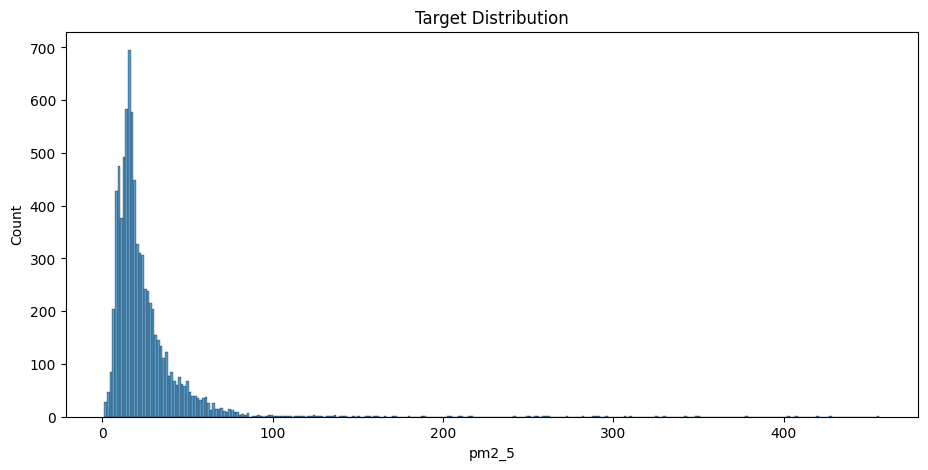

In [13]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- > The Target Variable(pm2_5) is right skewed: more data is concentrated to the right

In [14]:
train['pm2_5'].describe()

count    8071.000000
mean       24.639296
std        24.878920
min         1.200000
25%        13.270600
50%        18.375400
75%        28.838400
max       456.193333
Name: pm2_5, dtype: float64

<Axes: xlabel='pm2_5', ylabel='Density'>

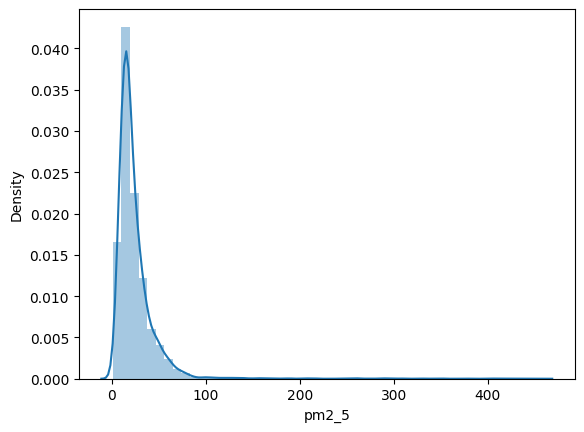

In [15]:
sns.distplot((train.pm2_5))

<Axes: xlabel='pm2_5', ylabel='Density'>

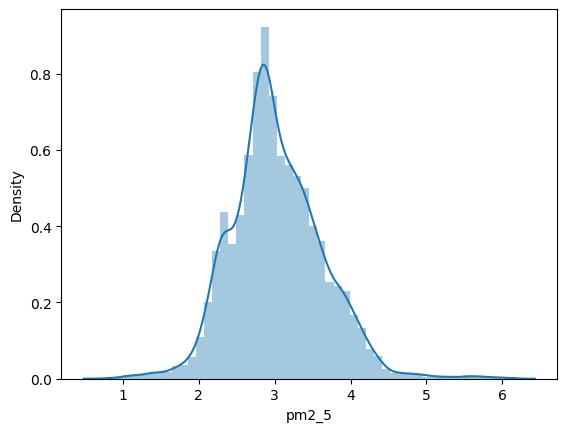

In [16]:
sns.distplot(np.log1p(train.pm2_5))

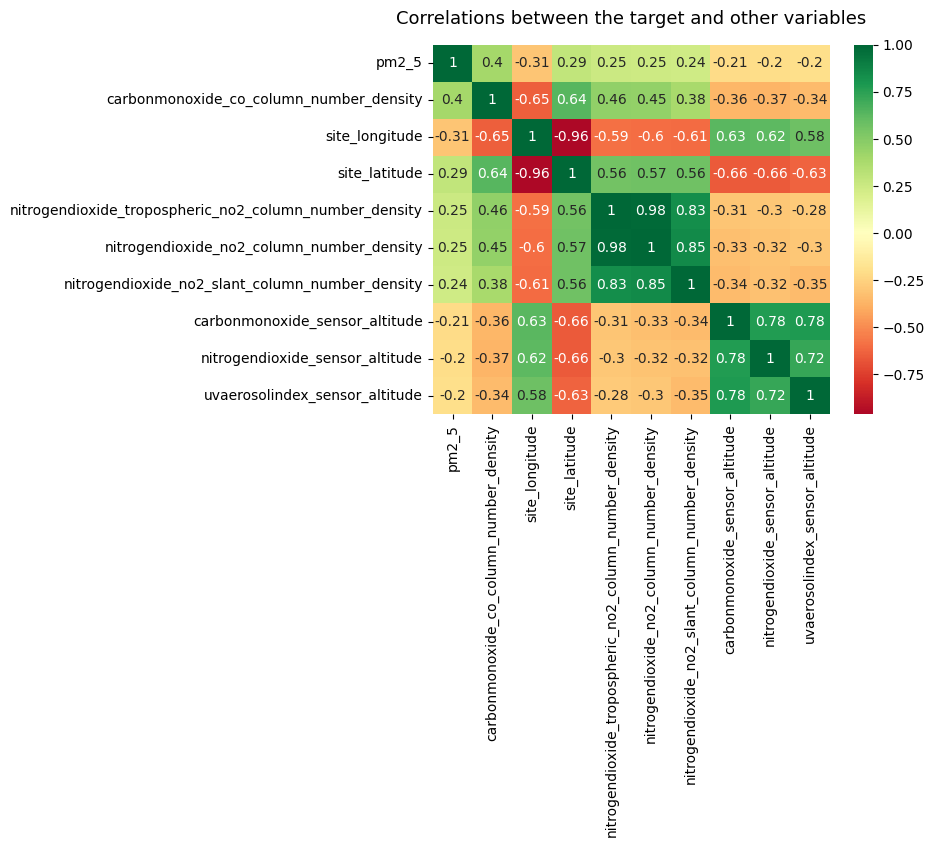

In [17]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [18]:

# Create folds before feature engineering
gkf = GroupKFold(n_splits = 4)
train['folds'] = np.nan

# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train.loc[test_index, 'folds'] = fold

# Convert fold indices to integer type
train['folds'] = train['folds'].astype(int)
train.groupby('folds')['pm2_5'].agg({'count'})

,count
folds,
1,5596
2,1500
3,852
4,123


In [19]:
train[(train['date']=='2023-10-25') & (train['city']=='Kampala')]

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,ozone_cloud_fraction,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,pm2_5,folds
421,id_bnzz82vs1f,60d058c8048305120d2d6156,0.351700,32.591000,Kampala,Uganda,2023-10-25,11,0.000176,0.887356,...,0.519771,0.513754,31886.857048,9415.787831,36683.276504,8415.787831,4.991480,0.307167,10.72830,1
568,id_hsain920tf,60d058c8048305120d2d615a,0.218200,32.617600,Kampala,Uganda,2023-10-25,11,-0.000296,0.878181,...,0.304247,0.303319,43368.523437,6987.647461,49297.640625,5987.647461,8.670818,0.184457,16.58720,1
825,id_hse0aqv6dj,616fe4ce9657420029658b3e,0.405320,32.620270,Kampala,Uganda,2023-10-25,11,0.000039,0.962259,...,0.306484,0.303005,66248.937500,3625.331299,75042.937500,2625.331299,8.315380,0.346472,13.98560,1
1208,id_elqte0s1z1,64a5755320511a001d1b4a3e,0.329891,32.598999,Kampala,Uganda,2023-10-25,11,0.000026,0.889452,...,0.616748,0.688106,38051.820313,8044.871094,43098.839844,7044.871094,7.826046,0.259927,11.10380,1
1430,id_5pa9pq67xp,62b310512e0eca001e0aab11,0.298330,32.600740,Kampala,Uganda,2023-10-25,11,-0.000132,0.887021,...,0.690820,0.688931,38075.457253,8037.917190,43138.459117,7037.917190,7.803655,0.259759,23.45730,1
1673,id_5xxfee2icn,60d058c8048305120d2d615c,0.356400,32.573000,Kampala,Uganda,2023-10-25,11,0.000326,0.891437,...,0.532644,0.531634,28352.408203,10193.101563,32811.738281,9193.101563,4.563959,0.307819,47.34780,1
1934,id_fen86w6ue2,624d2f9a994194001ddccbb6,0.288630,32.602970,Kampala,Uganda,2023-10-25,11,-0.000107,0.886516,...,0.689092,0.606927,38548.301360,7946.381843,43805.826209,6946.381884,7.491056,0.259607,15.57630,1
2198,id_5bylowr7h6,60d058c8048305120d2d6154,0.344000,32.553000,Kampala,Uganda,2023-10-25,11,0.000294,0.890894,...,0.532644,0.531634,28352.408203,10193.101562,32811.738281,9193.101562,4.563959,0.307819,24.33010,1
2711,id_j11a8zijyz,623d83620e8054001eaaa982,0.308520,32.592240,Kampala,Uganda,2023-10-25,11,0.000038,0.887143,...,0.688971,0.688106,38051.820313,8044.871094,43098.839844,7044.871094,7.826046,0.259927,25.06490,1
2915,id_f6jt57bht5,60d058c8048305120d2d6149,0.347014,32.649360,Kampala,Uganda,2023-10-25,11,-0.000075,0.884998,...,0.488075,0.489272,36934.601545,8323.031424,42207.379485,7323.031424,5.606781,0.306071,16.31450,1


In [20]:
numerical_cols

Index(['site_latitude', 'site_longitude', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction', 'nitrogendioxide_sensor_altitude',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric

## Feature Engineering

In [21]:
def feature_engineering(train,test):
    le = LabelEncoder()
     
    data = pd.concat([train, test])
    # capping before feature interactions
    skewed = ['pm2_5','hour']
    data[skewed].describe(percentiles=[0.05,0.95])
    
    #Feature interactions
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data['sulphurdioxide_no2_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['carbonmonoxide_no2_interaction'] = data['carbonmonoxide_co_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['formaldehyde_ozone_interaction'] = data['formaldehyde_tropospheric_hcho_column_number_density'] + data['ozone_o3_column_number_density']
    
    data['sulphurdioxide_cloud_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['cloud_cloud_fraction']
    data['nitrogendioxide_cloud_interaction'] = data['nitrogendioxide_no2_column_number_density'] + data ['cloud_cloud_fraction']
    data['ozone_cloud_interaction'] = data['ozone_o3_column_number_density'] + data['cloud_cloud_fraction']
    
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='bfill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week
        
        
    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])


#   data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train, test)


In [22]:
test_df[independent_features].isnull().sum()

date                                                        0
hour                                                        0
sulphurdioxide_so2_column_number_density                    4
sulphurdioxide_so2_column_number_density_amf                4
sulphurdioxide_so2_slant_column_number_density              4
sulphurdioxide_cloud_fraction                               4
sulphurdioxide_so2_column_number_density_15km               4
month                                                       0
carbonmonoxide_co_column_number_density                     1
carbonmonoxide_h2o_column_number_density                    1
carbonmonoxide_cloud_height                                 1
carbonmonoxide_sensor_altitude                              1
nitrogendioxide_no2_column_number_density                   4
nitrogendioxide_tropospheric_no2_column_number_density      4
nitrogendioxide_stratospheric_no2_column_number_density     4
nitrogendioxide_no2_slant_column_number_density             4
nitrogen

In [23]:
training  = train_df[train_df['folds'].isin([1.0,3.0, 4.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape

((6571, 57), (1500, 57))

In [24]:
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )

Learning rate set to 0.068433
0:	learn: 24.2767160	test: 25.8949873	best: 25.8949873 (0)	total: 57.5ms	remaining: 57.4s
100:	learn: 12.7368777	test: 24.9032091	best: 24.8949930 (80)	total: 781ms	remaining: 6.95s
200:	learn: 10.0237164	test: 24.8730316	best: 24.8702704 (199)	total: 1.58s	remaining: 6.3s
300:	learn: 8.6684749	test: 24.9594828	best: 24.8702704 (199)	total: 2.3s	remaining: 5.34s
400:	learn: 7.7762932	test: 24.9941614	best: 24.8702704 (199)	total: 3.03s	remaining: 4.52s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 24.87027043
bestIteration = 199

Shrink model to first 200 iterations.


In [25]:
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
38,location,55.437566
40,carbonmonoxide_no2_interaction,5.304262
0,date,4.915058
8,carbonmonoxide_co_column_number_density,3.000065
48,week,2.769216
30,ozone_cloud_fraction,1.912986
37,cloud_surface_albedo,1.632421
15,nitrogendioxide_no2_slant_column_number_density,1.556283
3,sulphurdioxide_so2_column_number_density_amf,1.400948
25,uvaerosolindex_sensor_altitude,1.204441


**Check for Feature Importances**

In [26]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

array(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction',
       'nitrogendioxide_sensor_altitude',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density

In [27]:
len(non_zero_features)

49

In [28]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.75:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]
selected_columns

Index(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_cloud_fraction', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density_amf',
       'formaldehyde_cloud_fraction', 'uvaerosolindex_absorbing_aerosol_index',
       'ozone_o3_column_number_density', 'ozone_o3_column_number_density_amf',
       'ozone_o3_effective_temperature', 'ozone_cloud_fraction',
       'cloud_cloud_fraction', 'cloud_cloud_top

The selected columns means that those are the columns we will use to train our model

In [29]:
len(selected_columns)

31

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
!pip install optuna

## Training using Lightgbm Regressor using optuna as a hyperparameter optimization

In [33]:
import optuna
import lightgbm as lgb

# Define the objective function for Optuna
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }
    
    rmse_folds = []
    
    for fold in [1, 2, 3, 4]:
        print("*" * 100)
        df_train = train_df.copy()
        df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

        training = df_train[train_df['folds'] != fold]
        validation = df_train[df_train['folds'] == fold]

        # Training and evaluation
        y_train = training[dependent_feature]
        y_test = validation[dependent_feature]

        X_train = training[selected_columns]
        X_test = validation[selected_columns]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
        preds = model.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_folds.append(rmse)

    return np.mean(rmse_folds)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

# Train and evaluate the model using the best parameters
fold_pred = []
oof_pred = []

for fold in [1, 2, 3, 4]:
    print("*" * 100)
    df_train = train_df.copy()
    df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

    training = df_train[train_df['folds'] != fold]
    validation = df_train[df_train['folds'] == fold]

    # Training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print(f"RMSE for fold {fold} with best params: {rmse}")
    oof_pred.append(rmse)

    # Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)

print(f"The average RMSE across the 4 groups: {np.mean(oof_pred)}")


[I 2024-06-18 09:08:37,682] A new study created in memory with name: no-name-310b8931-2ebb-40be-902b-c5cab090a2b4


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:08:57,803] Trial 0 finished with value: 13.292089406049303 and parameters: {'num_leaves': 48, 'learning_rate': 0.09978373085915916, 'n_estimators': 801, 'min_child_samples': 60, 'subsample': 0.722518586412185, 'colsample_bytree': 0.7816356232426168, 'reg_alpha': 0.48681841384411206, 'reg_lambda': 0.8996373782268509}. Best is trial 0 with value: 13.292089406049303.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:09:14,517] Trial 1 finished with value: 13.10427018619577 and parameters: {'num_leaves': 44, 'learning_rate': 0.013759904067594749, 'n_estimators': 698, 'min_child_samples': 95, 'subsample': 0.9565886502126169, 'colsample_bytree': 0.8348065472363115, 'reg_alpha': 0.7426306093125766, 'reg_lambda': 0.2688908693020692}. Best is trial 1 with value: 13.10427018619577.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
***************************************

[I 2024-06-18 09:09:34,347] Trial 2 finished with value: 13.345066425710113 and parameters: {'num_leaves': 43, 'learning_rate': 0.011762922584113484, 'n_estimators': 830, 'min_child_samples': 40, 'subsample': 0.70316945576724, 'colsample_bytree': 0.7043863747665307, 'reg_alpha': 0.955444054500341, 'reg_lambda': 0.3341522527467785}. Best is trial 1 with value: 13.10427018619577.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:09:50,948] Trial 3 finished with value: 12.958124694945074 and parameters: {'num_leaves': 59, 'learning_rate': 0.027313042985847382, 'n_estimators': 521, 'min_child_samples': 31, 'subsample': 0.903456664787444, 'colsample_bytree': 0.7918783021940857, 'reg_alpha': 0.1648307484235666, 'reg_lambda': 0.4760289624672056}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:10:14,251] Trial 4 finished with value: 13.248286898873786 and parameters: {'num_leaves': 48, 'learning_rate': 0.017154758045557352, 'n_estimators': 799, 'min_child_samples': 50, 'subsample': 0.7501081836592582, 'colsample_bytree': 0.9160853433031839, 'reg_alpha': 0.22345364199353512, 'reg_lambda': 0.6369752414761952}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:10:32,160] Trial 5 finished with value: 13.135279733650648 and parameters: {'num_leaves': 36, 'learning_rate': 0.01325594925226673, 'n_estimators': 850, 'min_child_samples': 97, 'subsample': 0.8561682247006055, 'colsample_bytree': 0.7903254420638212, 'reg_alpha': 0.5252691994247849, 'reg_lambda': 0.18749895417377793}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:10:41,200] Trial 6 finished with value: 13.155417117496661 and parameters: {'num_leaves': 54, 'learning_rate': 0.055178812278815145, 'n_estimators': 312, 'min_child_samples': 38, 'subsample': 0.8552353926369953, 'colsample_bytree': 0.8133388651264568, 'reg_alpha': 0.2707668299357766, 'reg_lambda': 0.9796354091380216}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:10:47,246] Trial 7 finished with value: 13.089753142264168 and parameters: {'num_leaves': 50, 'learning_rate': 0.0375875481706096, 'n_estimators': 222, 'min_child_samples': 62, 'subsample': 0.7568014152115836, 'colsample_bytree': 0.8199076299399017, 'reg_alpha': 0.706933448350705, 'reg_lambda': 0.8766607508246577}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:10:54,968] Trial 8 finished with value: 13.299064409708095 and parameters: {'num_leaves': 55, 'learning_rate': 0.06054667090605059, 'n_estimators': 211, 'min_child_samples': 26, 'subsample': 0.7633260366650082, 'colsample_bytree': 0.9367182392787197, 'reg_alpha': 0.7786513681956788, 'reg_lambda': 0.02201553824740865}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
***************************************

[I 2024-06-18 09:11:04,517] Trial 9 finished with value: 13.254786127685794 and parameters: {'num_leaves': 62, 'learning_rate': 0.012508378677664139, 'n_estimators': 223, 'min_child_samples': 27, 'subsample': 0.7782577172115468, 'colsample_bytree': 0.9641066074007609, 'reg_alpha': 0.31564945238947584, 'reg_lambda': 0.7469450281816415}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:11:18,332] Trial 10 finished with value: 13.204672799422411 and parameters: {'num_leaves': 69, 'learning_rate': 0.023360546019702288, 'n_estimators': 510, 'min_child_samples': 76, 'subsample': 0.9561444543160467, 'colsample_bytree': 0.7441143631194819, 'reg_alpha': 0.039171623056471594, 'reg_lambda': 0.5308842175259947}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:11:31,754] Trial 11 finished with value: 13.201715413980864 and parameters: {'num_leaves': 61, 'learning_rate': 0.031460428183381094, 'n_estimators': 448, 'min_child_samples': 75, 'subsample': 0.9112436859664456, 'colsample_bytree': 0.8730993298972524, 'reg_alpha': 0.01447692541701645, 'reg_lambda': 0.45062302917708813}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:11:43,605] Trial 12 finished with value: 13.296780439831066 and parameters: {'num_leaves': 59, 'learning_rate': 0.040895806858570125, 'n_estimators': 393, 'min_child_samples': 68, 'subsample': 0.817235924985414, 'colsample_bytree': 0.8697432128700615, 'reg_alpha': 0.5664306783286375, 'reg_lambda': 0.7431561680667451}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:11:47,397] Trial 13 finished with value: 13.183693768430826 and parameters: {'num_leaves': 69, 'learning_rate': 0.025830900832765055, 'n_estimators': 115, 'min_child_samples': 53, 'subsample': 0.8971153724360089, 'colsample_bytree': 0.7600985023403746, 'reg_alpha': 0.7486647607019924, 'reg_lambda': 0.48095764009618724}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:12:01,619] Trial 14 finished with value: 13.165206477781005 and parameters: {'num_leaves': 40, 'learning_rate': 0.04361592017496985, 'n_estimators': 581, 'min_child_samples': 40, 'subsample': 0.8109304358513847, 'colsample_bytree': 0.8491774526356497, 'reg_alpha': 0.39941279953957987, 'reg_lambda': 0.8241688528424783}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:12:11,608] Trial 15 finished with value: 13.232925036388925 and parameters: {'num_leaves': 31, 'learning_rate': 0.020535749995036972, 'n_estimators': 553, 'min_child_samples': 80, 'subsample': 0.9979068574646871, 'colsample_bytree': 0.7021310996114463, 'reg_alpha': 0.9731487976429407, 'reg_lambda': 0.5998451398438116}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:12:39,470] Trial 16 finished with value: 13.30468871520823 and parameters: {'num_leaves': 53, 'learning_rate': 0.033598434155706534, 'n_estimators': 959, 'min_child_samples': 62, 'subsample': 0.8943725393782237, 'colsample_bytree': 0.8980293564435065, 'reg_alpha': 0.16063125282041626, 'reg_lambda': 0.4041814887868805}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:12:51,068] Trial 17 finished with value: 13.075611099694218 and parameters: {'num_leaves': 64, 'learning_rate': 0.0755860926146187, 'n_estimators': 348, 'min_child_samples': 20, 'subsample': 0.8204070193784028, 'colsample_bytree': 0.8115488655719199, 'reg_alpha': 0.6434937817569646, 'reg_lambda': 0.6735973216905041}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:13:11,202] Trial 18 finished with value: 13.402883613035652 and parameters: {'num_leaves': 65, 'learning_rate': 0.098248963174326, 'n_estimators': 667, 'min_child_samples': 26, 'subsample': 0.8231881574725449, 'colsample_bytree': 0.7404717089445004, 'reg_alpha': 0.6339980375132392, 'reg_lambda': 0.6288893802972308}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:13:25,190] Trial 19 finished with value: 13.473738165750834 and parameters: {'num_leaves': 58, 'learning_rate': 0.0722038384520072, 'n_estimators': 378, 'min_child_samples': 20, 'subsample': 0.8768192625924716, 'colsample_bytree': 0.9975573612275529, 'reg_alpha': 0.400217398555604, 'reg_lambda': 0.7344614621519823}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:13:45,373] Trial 20 finished with value: 13.37144913094653 and parameters: {'num_leaves': 65, 'learning_rate': 0.07268174379818923, 'n_estimators': 632, 'min_child_samples': 34, 'subsample': 0.9319727486088262, 'colsample_bytree': 0.7913299778594254, 'reg_alpha': 0.8672167620816864, 'reg_lambda': 0.15865181423842656}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:13:53,168] Trial 21 finished with value: 13.122031546226324 and parameters: {'num_leaves': 51, 'learning_rate': 0.044331874516998264, 'n_estimators': 277, 'min_child_samples': 46, 'subsample': 0.7878779956789901, 'colsample_bytree': 0.8184861010392909, 'reg_alpha': 0.6815029644975148, 'reg_lambda': 0.9938783254633612}. Best is trial 3 with value: 12.958124694945074.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:14:05,223] Trial 22 finished with value: 12.949794237257997 and parameters: {'num_leaves': 56, 'learning_rate': 0.028037567581860594, 'n_estimators': 363, 'min_child_samples': 21, 'subsample': 0.7374286731682853, 'colsample_bytree': 0.811419625019044, 'reg_alpha': 0.6521366953696521, 'reg_lambda': 0.8570987282519245}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:14:19,548] Trial 23 finished with value: 13.05734959324785 and parameters: {'num_leaves': 56, 'learning_rate': 0.02689109341035571, 'n_estimators': 461, 'min_child_samples': 20, 'subsample': 0.8386599048549893, 'colsample_bytree': 0.7839870217492386, 'reg_alpha': 0.5857506012439505, 'reg_lambda': 0.5702477509651557}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:14:34,364] Trial 24 finished with value: 13.032181718483852 and parameters: {'num_leaves': 57, 'learning_rate': 0.02766762421361879, 'n_estimators': 491, 'min_child_samples': 32, 'subsample': 0.9332809138092812, 'colsample_bytree': 0.7615996671278134, 'reg_alpha': 0.447354163207726, 'reg_lambda': 0.5436452425189864}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:14:48,373] Trial 25 finished with value: 13.103416224897519 and parameters: {'num_leaves': 58, 'learning_rate': 0.017399987830920803, 'n_estimators': 461, 'min_child_samples': 32, 'subsample': 0.9281762547565486, 'colsample_bytree': 0.7560258166473373, 'reg_alpha': 0.40269834740786503, 'reg_lambda': 0.33340300618553403}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:15:04,078] Trial 26 finished with value: 13.140385532914076 and parameters: {'num_leaves': 60, 'learning_rate': 0.028456034767631574, 'n_estimators': 525, 'min_child_samples': 31, 'subsample': 0.9821735816004957, 'colsample_bytree': 0.7269724428180296, 'reg_alpha': 0.14087365711239322, 'reg_lambda': 0.40693177327294283}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:15:24,142] Trial 27 finished with value: 13.10376218572252 and parameters: {'num_leaves': 56, 'learning_rate': 0.021120443584739815, 'n_estimators': 718, 'min_child_samples': 45, 'subsample': 0.8772233482418569, 'colsample_bytree': 0.7665647206844446, 'reg_alpha': 0.48102301825790517, 'reg_lambda': 0.8178211982991892}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:15:42,436] Trial 28 finished with value: 13.329880405811785 and parameters: {'num_leaves': 52, 'learning_rate': 0.0311622503956468, 'n_estimators': 602, 'min_child_samples': 36, 'subsample': 0.9409837582613111, 'colsample_bytree': 0.8551976625874849, 'reg_alpha': 0.8593734131274535, 'reg_lambda': 0.5321039313971134}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:15:54,930] Trial 29 finished with value: 13.078611503215704 and parameters: {'num_leaves': 47, 'learning_rate': 0.019798222866231036, 'n_estimators': 446, 'min_child_samples': 28, 'subsample': 0.7271845676460433, 'colsample_bytree': 0.7744932251241043, 'reg_alpha': 0.4625325120492314, 'reg_lambda': 0.9113088139896843}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:16:07,568] Trial 30 finished with value: 13.159025515801261 and parameters: {'num_leaves': 63, 'learning_rate': 0.010286463312748488, 'n_estimators': 391, 'min_child_samples': 45, 'subsample': 0.9697950292341395, 'colsample_bytree': 0.8005800582591851, 'reg_alpha': 0.3380871702490944, 'reg_lambda': 0.6802194294905505}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:16:22,251] Trial 31 finished with value: 12.952911033596793 and parameters: {'num_leaves': 56, 'learning_rate': 0.026097145762941882, 'n_estimators': 470, 'min_child_samples': 20, 'subsample': 0.9152132315914829, 'colsample_bytree': 0.7889861722125505, 'reg_alpha': 0.5656838743793152, 'reg_lambda': 0.5646050782185226}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:16:36,929] Trial 32 finished with value: 13.122466422225502 and parameters: {'num_leaves': 57, 'learning_rate': 0.024382546725679473, 'n_estimators': 501, 'min_child_samples': 24, 'subsample': 0.908584825616502, 'colsample_bytree': 0.723737271189837, 'reg_alpha': 0.5841813484064625, 'reg_lambda': 0.4582369083512647}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:16:49,894] Trial 33 finished with value: 13.076016477377177 and parameters: {'num_leaves': 49, 'learning_rate': 0.016407361806428093, 'n_estimators': 422, 'min_child_samples': 32, 'subsample': 0.8774826716143914, 'colsample_bytree': 0.8340279385784599, 'reg_alpha': 0.0928300252813427, 'reg_lambda': 0.3194594400831591}. Best is trial 22 with value: 12.949794237257997.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:16:56,366] Trial 34 finished with value: 12.924006546106067 and parameters: {'num_leaves': 46, 'learning_rate': 0.03537411980599099, 'n_estimators': 275, 'min_child_samples': 87, 'subsample': 0.950395449236644, 'colsample_bytree': 0.7744956275578709, 'reg_alpha': 0.8110050240954035, 'reg_lambda': 0.2598561375421812}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:16:59,563] Trial 35 finished with value: 13.162267137976931 and parameters: {'num_leaves': 45, 'learning_rate': 0.0348580992044593, 'n_estimators': 122, 'min_child_samples': 85, 'subsample': 0.9556526873117414, 'colsample_bytree': 0.8413757749134739, 'reg_alpha': 0.847030210431905, 'reg_lambda': 0.23128927257173568}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:06,211] Trial 36 finished with value: 13.100884455728156 and parameters: {'num_leaves': 41, 'learning_rate': 0.04967127585230364, 'n_estimators': 292, 'min_child_samples': 100, 'subsample': 0.7022301553004824, 'colsample_bytree': 0.7991258542258421, 'reg_alpha': 0.9248376550860989, 'reg_lambda': 0.04826348314737772}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:15,174] Trial 37 finished with value: 13.150924300425233 and parameters: {'num_leaves': 45, 'learning_rate': 0.0378057113341599, 'n_estimators': 335, 'min_child_samples': 56, 'subsample': 0.9183646439765659, 'colsample_bytree': 0.8294617609761087, 'reg_alpha': 0.767853111321542, 'reg_lambda': 0.1540768391967957}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:19,129] Trial 38 finished with value: 13.01460458299699 and parameters: {'num_leaves': 47, 'learning_rate': 0.02268977643507084, 'n_estimators': 164, 'min_child_samples': 90, 'subsample': 0.733466747746199, 'colsample_bytree': 0.7790705519731382, 'reg_alpha': 0.5386089261204949, 'reg_lambda': 0.2864623913291017}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:26,328] Trial 39 finished with value: 13.209067784137922 and parameters: {'num_leaves': 54, 'learning_rate': 0.029751068663646234, 'n_estimators': 259, 'min_child_samples': 70, 'subsample': 0.8921271518641699, 'colsample_bytree': 0.8094605245580664, 'reg_alpha': 0.6899929598007513, 'reg_lambda': 0.3821238650094596}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:41,383] Trial 40 finished with value: 13.208877815847982 and parameters: {'num_leaves': 38, 'learning_rate': 0.01477638467058717, 'n_estimators': 734, 'min_child_samples': 92, 'subsample': 0.9502303155743255, 'colsample_bytree': 0.7427445775209925, 'reg_alpha': 0.8002778728149612, 'reg_lambda': 0.0881801780842385}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:45,224] Trial 41 finished with value: 13.070573026070385 and parameters: {'num_leaves': 47, 'learning_rate': 0.02335938041393664, 'n_estimators': 159, 'min_child_samples': 89, 'subsample': 0.7279273624812931, 'colsample_bytree': 0.7792404628959497, 'reg_alpha': 0.5033143109490945, 'reg_lambda': 0.2645535979035758}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:49,363] Trial 42 finished with value: 13.193039077035742 and parameters: {'num_leaves': 42, 'learning_rate': 0.0224957991489151, 'n_estimators': 179, 'min_child_samples': 83, 'subsample': 0.7433573692276465, 'colsample_bytree': 0.7884083310318202, 'reg_alpha': 0.5432986294362567, 'reg_lambda': 0.2821875756913946}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:17:57,554] Trial 43 finished with value: 13.034965348328805 and parameters: {'num_leaves': 51, 'learning_rate': 0.019026734879534307, 'n_estimators': 330, 'min_child_samples': 94, 'subsample': 0.7765499314590715, 'colsample_bytree': 0.8014433770461572, 'reg_alpha': 0.6156202855500704, 'reg_lambda': 0.22218933683209197}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6725
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 31
[LightGBM] [Info] Start training from score 24.290364
****************************************************************************************************
[LightGBM] [I

[I 2024-06-18 09:18:04,864] Trial 44 finished with value: 13.132334078128117 and parameters: {'num_leaves': 49, 'learning_rate': 0.036061576462188834, 'n_estimators': 245, 'min_child_samples': 24, 'subsample': 0.7185219673165557, 'colsample_bytree': 0.7743691657019893, 'reg_alpha': 0.7257058575142502, 'reg_lambda': 0.3821685950131136}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:18:09,126] Trial 45 finished with value: 13.102796347603197 and parameters: {'num_leaves': 44, 'learning_rate': 0.03213170021673337, 'n_estimators': 197, 'min_child_samples': 90, 'subsample': 0.7433421873819457, 'colsample_bytree': 0.7237064361373801, 'reg_alpha': 0.5304551788308377, 'reg_lambda': 0.9437826759095272}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:18:17,694] Trial 46 finished with value: 13.128129559903421 and parameters: {'num_leaves': 54, 'learning_rate': 0.025084526213477048, 'n_estimators': 361, 'min_child_samples': 99, 'subsample': 0.7932922368200959, 'colsample_bytree': 0.7504641376941631, 'reg_alpha': 0.228728893430872, 'reg_lambda': 0.12179754882513169}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:18:22,210] Trial 47 finished with value: 13.138503395508968 and parameters: {'num_leaves': 61, 'learning_rate': 0.03990289099637732, 'n_estimators': 152, 'min_child_samples': 75, 'subsample': 0.8598454653485665, 'colsample_bytree': 0.824414906945747, 'reg_alpha': 0.34126953748306094, 'reg_lambda': 0.2878401174965352}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:18:30,591] Trial 48 finished with value: 13.2056129273904 and parameters: {'num_leaves': 48, 'learning_rate': 0.029098587412965296, 'n_estimators': 303, 'min_child_samples': 67, 'subsample': 0.973997602910739, 'colsample_bytree': 0.87181140499743, 'reg_alpha': 0.6643471930096527, 'reg_lambda': 0.8185684723307667}. Best is trial 34 with value: 12.924006546106067.


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 09:18:36,372] Trial 49 finished with value: 13.199559506072099 and parameters: {'num_leaves': 52, 'learning_rate': 0.01794034168672578, 'n_estimators': 233, 'min_child_samples': 86, 'subsample': 0.8439019910966209, 'colsample_bytree': 0.7698966988516914, 'reg_alpha': 0.8067719790593335, 'reg_lambda': 0.43296016622197125}. Best is trial 34 with value: 12.924006546106067.


Best hyperparameters found by Optuna:
{'num_leaves': 46, 'learning_rate': 0.03537411980599099, 'n_estimators': 275, 'min_child_samples': 87, 'subsample': 0.950395449236644, 'colsample_bytree': 0.7744956275578709, 'reg_alpha': 0.8110050240954035, 'reg_lambda': 0.2598561375421812}
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 31
[LightGBM] [Info] Start training from score 24.314190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

RMSE for fold 4: 10.708729405723403
The average RMSE across the 4 groups: 13.14351175786114

Shrink model to first 36 iterations.
RMSE for fold :4 : 10.601998810775408
The average rmse across the 4 groups: 12.99836047679286

## Visualise the Feature Importances

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

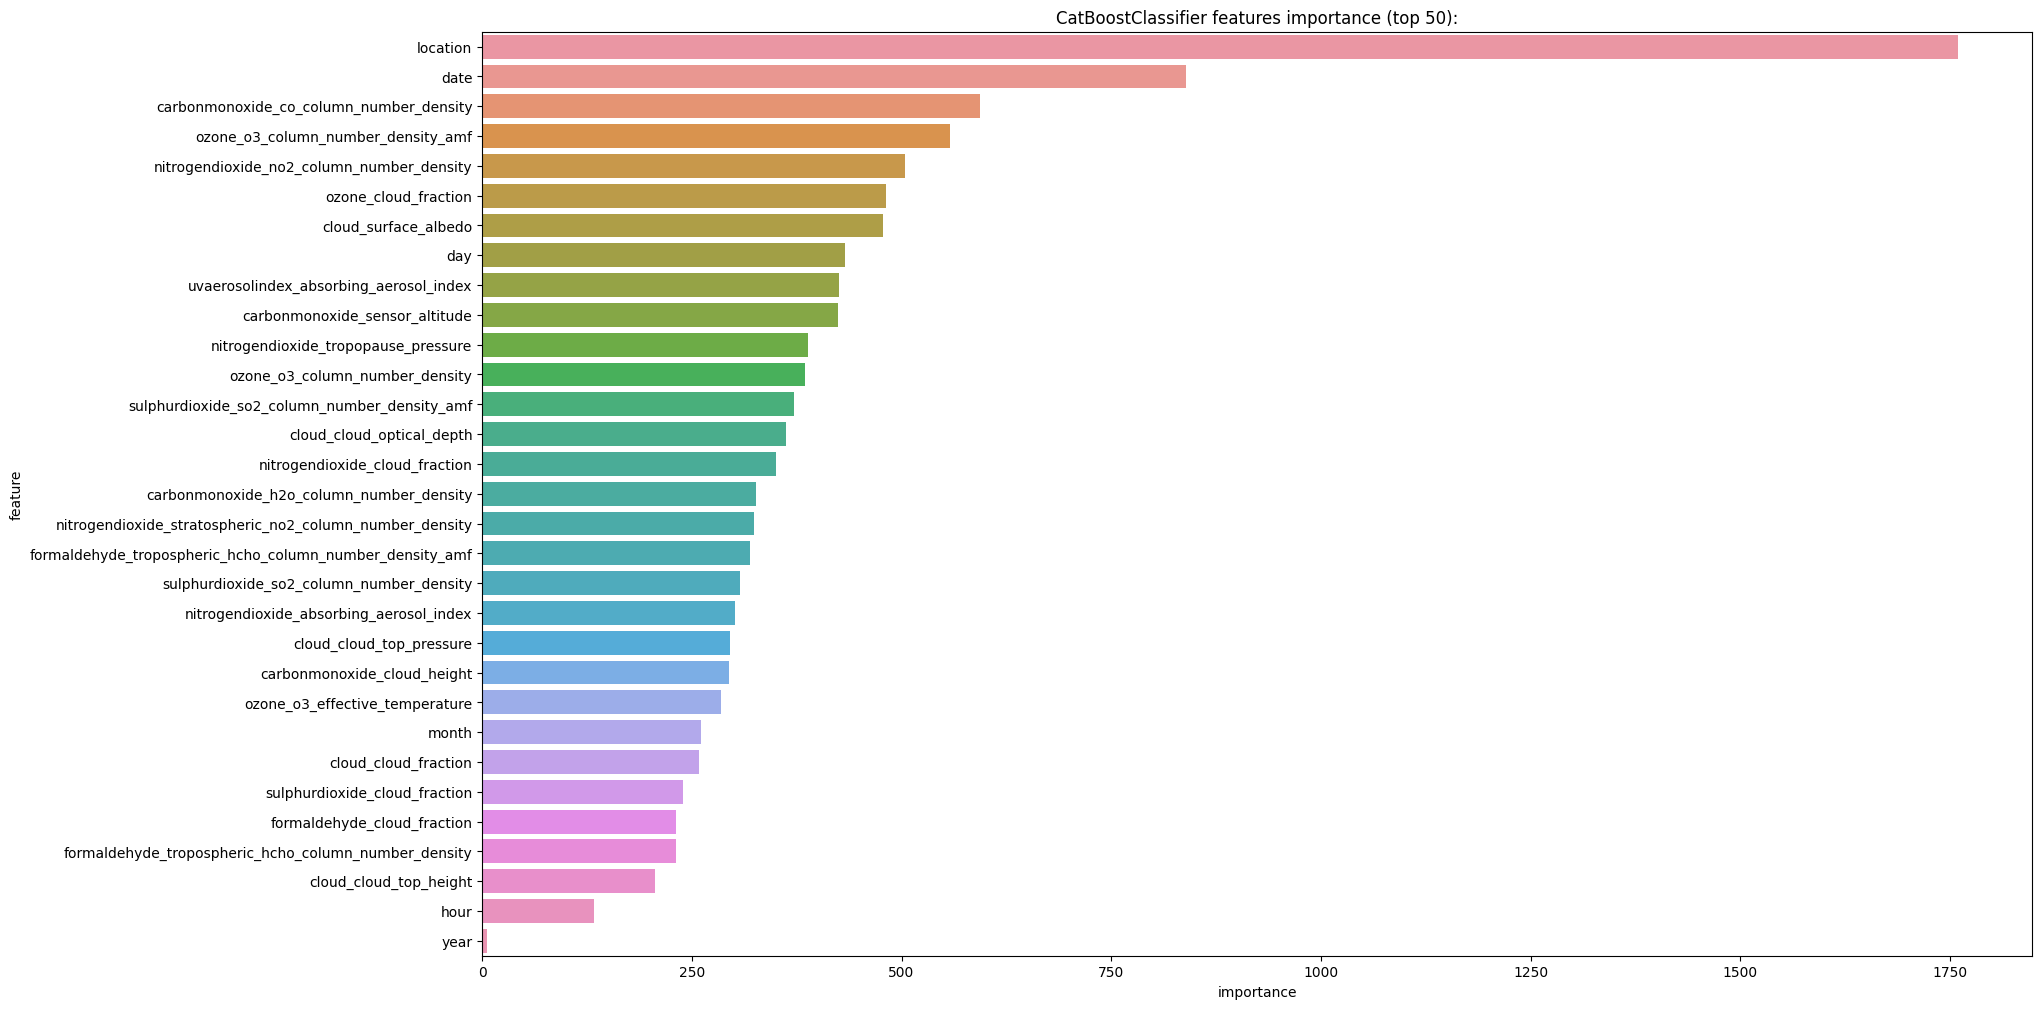

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

In [37]:
pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()

,id,pred
214,id_yorywxet0a,19.229174
215,id_9rhbkh8kye,17.042964
216,id_oh2pg7ik9m,16.305120
217,id_u5xtrnbshq,19.534562
218,id_pfcdhqpggy,16.491874


In [36]:
sub.to_csv('baseline_12_64.csv', index= False)